## Allianz EDA
### Prueba Técnica para Científico de Datos
Norma Giraldo

In [ ]:
# importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_palette("muted")  # o "deep", "pastel", "dark"
import plotly.express as px
import plotly.graph_objects as go

In [1]:
# adicionar directorio src a sys.path
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
from preprocessing import format_columns, apply_filters, clean_text_columns

# Ruta datos consolidados
data_path = "C:/Allianz/prueba_allianz/data/processed/allianz_consolidado.csv"

# Cargar datos consolidados
df_all = pd.read_csv(data_path, sep=";", encoding="utf-8", dtype=str)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087581 entries, 0 to 2087580
Data columns (total 32 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   fecha_registro             object
 1   comparison_id              object
 2   fecha_nacimiento           object
 3   edad                       object
 4   ocupacion                  object
 5   tipo_identificacion        object
 6   genero                     object
 7   fasecolda_id               object
 8   marca                      object
 9   clase                      object
 10  referencia_vehiculo        object
 11  vehiculo_uso               object
 12  tipo_caja                  object
 13  valor_fasecolda            object
 14  modelo                     object
 15  dane_id                    object
 16  ciudad                     object
 17  departamento_id            object
 18  departamento               object
 19  vehiculo_nuevo             object
 20  aseguradora_producto    

In [3]:
# Formatea las columnas
df_all = format_columns(df_all)
# Depura textos en columnas
df_all = clean_text_columns(df_all)
# Filtros de datos solicitados
df_filtered = apply_filters(df_all)
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fecha_registro             684316 non-null  object 
 1   comparison_id              684316 non-null  object 
 2   fecha_nacimiento           582229 non-null  object 
 3   edad                       684316 non-null  int64  
 4   ocupacion                  684316 non-null  object 
 5   tipo_identificacion        684316 non-null  object 
 6   genero                     684316 non-null  object 
 7   fasecolda_id               684316 non-null  object 
 8   marca                      684316 non-null  object 
 9   clase                      684316 non-null  object 
 10  referencia_vehiculo        684316 non-null  object 
 11  vehiculo_uso               684316 non-null  object 
 12  tipo_caja                  684105 non-null  object 
 13  valor_fasecolda            68

### Evaluar Datos faltantes

In [4]:
faltantes = df_filtered.isnull().sum()
faltantes = faltantes[faltantes > 0].sort_values(ascending=False)

faltantes_percent = (faltantes / len(df_filtered) * 100).round(2)

df_nulos = pd.DataFrame({
    'faltantes': faltantes,
    'porcentaje': faltantes_percent
})

df_nulos

,faltantes,porcentaje
emitido_producto,521025,76.14
fecha_nacimiento,102087,14.92
competencia,44696,6.53
perdida_total_cobertura,18835,2.75
tipo_caja,211,0.03
ciudad,6,0.00
departamento,6,0.00


Acciones a tomar:

- emitido_producto: Posible target dicotomico emitido - no emitido
- fecha_nacimiento: Eliminar por redundancia con edad.
- competencia: No se considera relevante
- perdida_total_cobertura: Proceso de imputacion de datos mediante modelo de clasificación
- tipo_caja: Imputar NaN por No_disponible
- ciudad: Corregir error de digitacion en dane_id = IBAGUE
- departamento: se extrae de la ciudad

### Imputación de datos

In [5]:
# Completar información faltante en ciudad y departamento
df_filtered.loc[df_filtered['dane_id'] == 'IBAGUE', 'dane_id'] = '73001'
df_filtered.loc[df_filtered['dane_id'] == '73001', 'ciudad'] = 'Ibagué'
df_filtered.loc[df_filtered['dane_id'] == '73001', 'departamento'] = 'Tolima'
df_filtered.loc[df_filtered['dane_id'] == '73001', 'departamento_id'] = '73'

In [6]:
df_filtered['tipo_caja'] = df_filtered['tipo_caja'].fillna("No_disponible")

c:\Allianz\prueba_allianz\src\imput_data.py:84: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


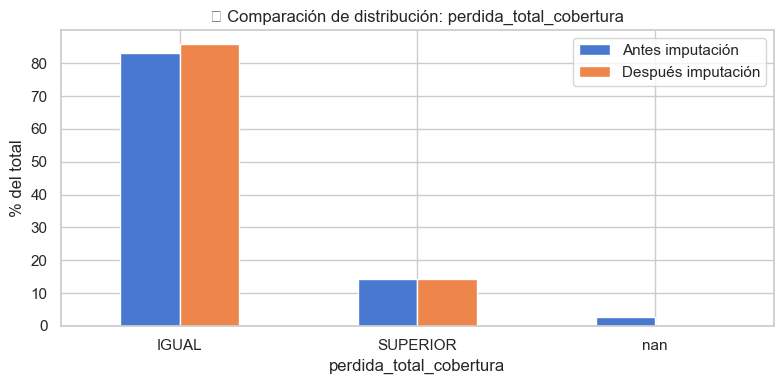

,Antes imputación,Después imputación
perdida_total_cobertura,,
IGUAL,82.97,85.69
SUPERIOR,14.28,14.31
NaN,2.75,0.00


In [7]:
from imput_data import imputar_perdida_total_cobertura, reporte_imputacion_distribucion

# Guardar copia antes de imputar
df_original = df_filtered.copy()

features = [
    'edad', 'genero', 'ocupacion', 'valor_prima', 'modelo', 'ciudad', 'marca',
    'aseguradora_producto', 'tipo_cobertura', 'vehiculo_nuevo', 'perdida_parcial_deducible'
]

# Aplicar imputación
df_filtered = imputar_perdida_total_cobertura(df_filtered, target='perdida_total_cobertura', features=features)

# Generar reporte gráfico y tabla
reporte_imputacion_distribucion(df_original, df_filtered, columna='perdida_total_cobertura')


In [9]:
df_filtered.drop(columns=['competencia'], inplace=True)

### Columnas de único valor o redundantes

In [10]:
solo_un_valor = df_filtered.nunique()
variables_inutiles = solo_un_valor[solo_un_valor == 1].index.tolist()
print("⚠️ Variables con un único valor:", variables_inutiles)

⚠️ Variables con un único valor: ['clase', 'vehiculo_uso', 'tipo_cobertura', 'rce']


In [11]:
df_filtered.drop(columns=['clase', 'vehiculo_uso', 'tipo_cobertura', 'rce'], inplace=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fecha_registro             684316 non-null  object 
 1   comparison_id              684316 non-null  object 
 2   fecha_nacimiento           582229 non-null  object 
 3   edad                       684316 non-null  int64  
 4   ocupacion                  684316 non-null  object 
 5   tipo_identificacion        684316 non-null  object 
 6   genero                     684316 non-null  object 
 7   fasecolda_id               684316 non-null  object 
 8   marca                      684316 non-null  object 
 9   referencia_vehiculo        684316 non-null  object 
 10  tipo_caja                  684316 non-null  object 
 11  valor_fasecolda            684316 non-null  int64  
 12  modelo                     684316 non-null  int64  
 13  dane_id                    68

In [12]:
# Almacenar el DataFrame inicial para futuras comparaciones
df_initial = df_filtered.copy()

### Tratamiento de las columnas fecha

In [13]:
# Visualizar registros con errores
df_filtered[df_filtered['fecha_nacimiento'] == '0199-02-23']

,fecha_registro,comparison_id,fecha_nacimiento,edad,ocupacion,tipo_identificacion,genero,fasecolda_id,marca,referencia_vehiculo,tipo_caja,valor_fasecolda,modelo,dane_id,ciudad,departamento_id,departamento,vehiculo_nuevo,aseguradora_producto,cotizacion_fecha,valor_prima,perdida_total_cobertura,perdida_parcial_deducible,rce_limite_unico,emitido_producto,emitido_cotizacion,source_file
495841,2024-09-04T16:44:37.534Z,2dd57d00c07bd24b504d9f834028481e,0199-02-23,1825,Empleado,CC,Masculino,05601186,MAZDA,3 [4] GRAND TOURING LX TP 2500CC 7AB CT TC (AU...,TP,94000000,2022,76001,Cali,76,Valle del Cauca,Usado,Aseguradora8_Todo Riesgo Bajo,2024-09-04T16:49:22.957811349Z,8376354.0,IGUAL,INFERIOR,True,NaN,False,2024-9
495842,2024-09-04T16:44:37.534Z,2dd57d00c07bd24b504d9f834028481e,0199-02-23,1825,Empleado,CC,Masculino,05601186,MAZDA,3 [4] GRAND TOURING LX TP 2500CC 7AB CT TC (AU...,TP,94000000,2022,76001,Cali,76,Valle del Cauca,Usado,Aseguradora8_Todo Riesgo Bajo,2024-09-04T16:49:22.957643146Z,8074777.2,IGUAL,INFERIOR,True,NaN,False,2024-9
495843,2024-09-04T16:44:37.534Z,2dd57d00c07bd24b504d9f834028481e,0199-02-23,1825,Empleado,CC,Masculino,05601186,MAZDA,3 [4] GRAND TOURING LX TP 2500CC 7AB CT TC (AU...,TP,94000000,2022,76001,Cali,76,Valle del Cauca,Usado,Aseguradora8_Todo Riesgo Alto,2024-09-04T16:49:22.957750836Z,8182664.4,IGUAL,INFERIOR,True,NaN,False,2024-9
495844,2024-09-04T16:44:37.534Z,2dd57d00c07bd24b504d9f834028481e,0199-02-23,1825,Empleado,CC,Masculino,05601186,MAZDA,3 [4] GRAND TOURING LX TP 2500CC 7AB CT TC (AU...,TP,94000000,2022,76001,Cali,76,Valle del Cauca,Usado,Aseguradora8_Todo Riesgo Bajo,2024-09-04T16:49:22.957967367Z,7682679.6,IGUAL,INFERIOR,True,NaN,False,2024-9
495845,2024-09-04T16:44:37.534Z,2dd57d00c07bd24b504d9f834028481e,0199-02-23,1825,Empleado,CC,Masculino,05601186,MAZDA,3 [4] GRAND TOURING LX TP 2500CC 7AB CT TC (AU...,TP,94000000,2022,76001,Cali,76,Valle del Cauca,Usado,Aseguradora8_Todo Riesgo Alto,2024-09-04T16:49:22.957898636Z,7876369.2,IGUAL,INFERIOR,True,NaN,False,2024-9


In [14]:
# Reemplazar '0199' por '1990' en la columna de fechas
df_filtered['fecha_nacimiento'] = df_filtered['fecha_nacimiento'].str.replace('0199-02-23', '1990-02-23', regex=False)

In [15]:
df_filtered['fecha_nacimiento'] = pd.to_datetime(df_filtered['fecha_nacimiento'], format='%Y-%m-%d')
df_filtered['fecha_nacimiento'] = df_filtered['fecha_nacimiento'].dt.date

In [16]:
df_filtered['fecha_registro'] = pd.to_datetime(df_filtered['fecha_registro'], format="mixed")
df_filtered['fecha_registro'] = df_filtered['fecha_registro'].dt.date

In [17]:
df_filtered['cotizacion_fecha'] = pd.to_datetime(df_filtered['cotizacion_fecha'], format="mixed")
df_filtered['cotizacion_fecha'] = df_filtered['cotizacion_fecha'].dt.date

In [18]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fecha_registro             684316 non-null  object 
 1   comparison_id              684316 non-null  object 
 2   fecha_nacimiento           582229 non-null  object 
 3   edad                       684316 non-null  int64  
 4   ocupacion                  684316 non-null  object 
 5   tipo_identificacion        684316 non-null  object 
 6   genero                     684316 non-null  object 
 7   fasecolda_id               684316 non-null  object 
 8   marca                      684316 non-null  object 
 9   referencia_vehiculo        684316 non-null  object 
 10  tipo_caja                  684316 non-null  object 
 11  valor_fasecolda            684316 non-null  int64  
 12  modelo                     684316 non-null  int64  
 13  dane_id                    68

In [19]:
df_filtered['fecha_analisis'] = df_filtered['fecha_registro'] == df_filtered['cotizacion_fecha']
print("📌 Coincidencias de fecha:", df_filtered['fecha_analisis'].mean() * 100, "%")

📌 Coincidencias de fecha: 90.70137188082698 %


In [20]:
def analizar_diferencia_registro_cotizacion(df):
    """
    Analiza y visualiza la diferencia entre fecha_registro y cotizacion_fecha.
    Retorna resumen estadístico de delta_minutos.
    """
    # Calcular diferencia en minutos
    df['delta_minutos'] = (df['cotizacion_fecha'] - df['fecha_registro']).dt.total_seconds() / 60

    # Eliminar valores extremos para visualización (percentil 99)
    percentil_99 = df['delta_minutos'].quantile(0.99)
    df_plot = df[df['delta_minutos'] <= percentil_99]

    # Gráfico
    plt.figure(figsize=(10, 5))
    sns.histplot(df_plot['delta_minutos'], bins=50, kde=True)
    plt.title("⏱ Distribución del tiempo entre registro y cotización (minutos)")
    plt.xlabel("Diferencia en minutos")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    # Estadísticas descriptivas
    return df['delta_minutos'].describe()

In [21]:
columnas_fechas = ['cotizacion_fecha', 'fecha_registro']

for col in columnas_fechas:
    df_filtered[col] = pd.to_datetime(df_filtered[col].astype(str))

C:\Users\norma\AppData\Local\Temp\ipykernel_32728\3563582690.py:19: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


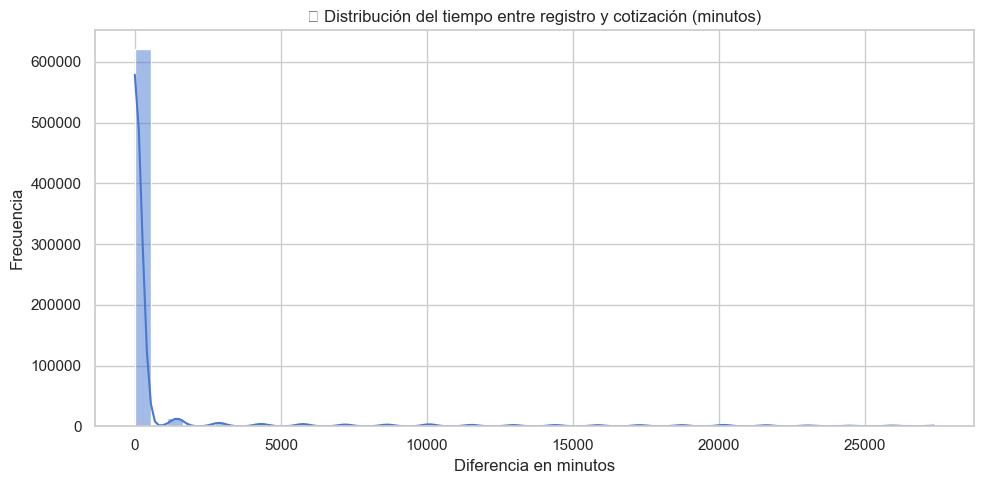

count    684316.000000
mean       1086.758983
std        4622.446538
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       43200.000000
Name: delta_minutos, dtype: float64

In [22]:
analizar_diferencia_registro_cotizacion(df_filtered)

In [23]:
# Revisar diferencias grandes
diff = df_filtered[df_filtered['delta_minutos'] > 0].reset_index(drop=True)
diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63632 entries, 0 to 63631
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   fecha_registro             63632 non-null  datetime64[ns]
 1   comparison_id              63632 non-null  object        
 2   fecha_nacimiento           52915 non-null  object        
 3   edad                       63632 non-null  int64         
 4   ocupacion                  63632 non-null  object        
 5   tipo_identificacion        63632 non-null  object        
 6   genero                     63632 non-null  object        
 7   fasecolda_id               63632 non-null  object        
 8   marca                      63632 non-null  object        
 9   referencia_vehiculo        63632 non-null  object        
 10  tipo_caja                  63632 non-null  object        
 11  valor_fasecolda            63632 non-null  int64         
 12  mode

C:\Users\norma\AppData\Local\Temp\ipykernel_32728\3563582690.py:19: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


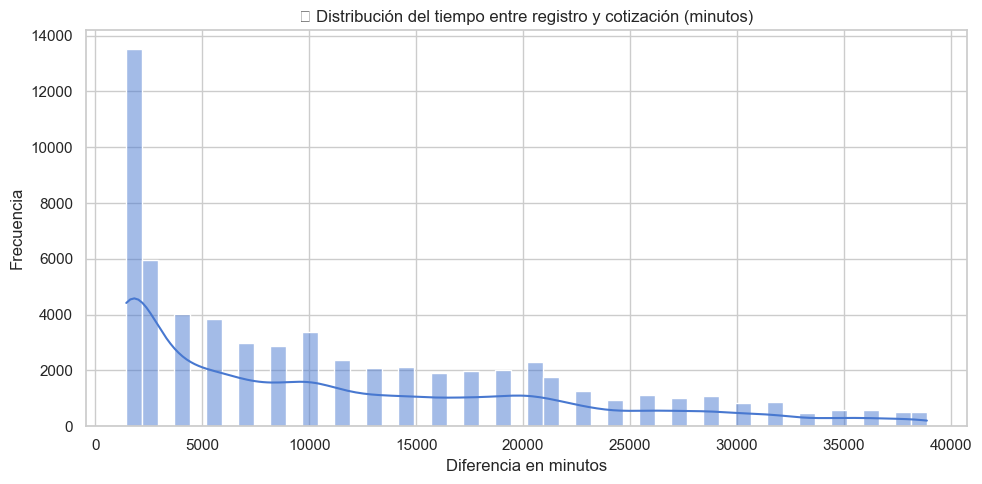

count    63632.000000
mean     11687.304501
std      10290.589825
min       1440.000000
25%       2880.000000
50%       8640.000000
75%      18720.000000
max      43200.000000
Name: delta_minutos, dtype: float64

In [24]:
analizar_diferencia_registro_cotizacion(diff)

In [26]:
print("⏱ Más de 1 hora:", (diff['delta_minutos'] > 60).sum())
print("📅 Más de 1 día:", (diff['delta_minutos'] > 1440).sum())
print("📆 Más de 1 semana:", (diff['delta_minutos'] > 10080).sum())

⏱ Más de 1 hora: 63632
📅 Más de 1 día: 50118
📆 Más de 1 semana: 27036


In [27]:
bins = [0, 60, 1440, 10080, diff['delta_minutos'].max()]
labels = ['≤1 hora', '1h–1d', '1d–1semana', '>1 semana']

diff['rango_tiempo'] = pd.cut(diff['delta_minutos'], bins=bins, labels=labels, include_lowest=True)

diff['rango_tiempo'].value_counts(normalize=True).mul(100).round(2)

rango_tiempo
>1 semana     42.49
1d–1semana    36.27
1h–1d         21.24
≤1 hora        0.00
Name: proportion, dtype: float64

In [28]:
bins = [0, 60, 1440, 10080, df_filtered['delta_minutos'].max()]
labels = ['≤1 hora', '1h–1d', '1d–1semana', '>1 semana']

df_filtered['rango_tiempo'] = pd.cut(df_filtered['delta_minutos'], bins=bins, labels=labels, include_lowest=True)

df_filtered['rango_tiempo'].value_counts(normalize=True).mul(100).round(2)

rango_tiempo
≤1 hora       90.70
>1 semana      3.95
1d–1semana     3.37
1h–1d          1.97
Name: proportion, dtype: float64

In [29]:
diff.groupby('aseguradora_producto')['delta_minutos'].mean().sort_values(ascending=False).head(10)

aseguradora_producto
Aseguradora11_RCE + Totales       16837.377049
Aseguradora11_RCE+Totales         16071.111111
Aseguradora11_TodoRiesgoBajo      16011.428571
Aseguradora5_RCE + Totales        15142.153846
Aseguradora5_Todo Riesgo Bajo     15027.969925
Aseguradora9_TodoRiesgoAlto       13537.425743
Aseguradora9_TodoRiesgoBajo       13147.534884
Aseguradora2_                     13113.034571
Aseguradora11_Todo Riesgo Bajo    12965.506692
Aseguradora6_n/a                  12728.546679
Name: delta_minutos, dtype: float64

c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


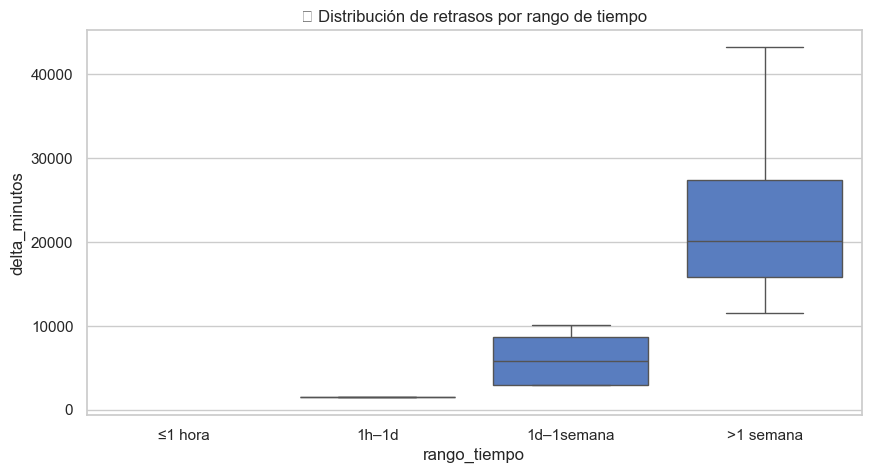

In [30]:
plt.figure(figsize=(10,5))
sns.boxplot(data=diff, x='rango_tiempo', y='delta_minutos')
plt.title("📦 Distribución de retrasos por rango de tiempo")
plt.show()

In [31]:
# Separar aseguradora_producto
diff[['aseguradora_origen', 'producto_origen']] = diff['aseguradora_producto'].str.split('_', n=1, expand=True)

In [32]:
diff.groupby('aseguradora_origen')['delta_minutos'].mean().sort_values(ascending=False).head()

aseguradora_origen
Aseguradora11    13712.893401
Aseguradora1     12335.612278
Aseguradora4     12229.886948
Aseguradora6     11982.745325
Aseguradora2     11889.463108
Name: delta_minutos, dtype: float64

In [33]:
diff['producto_origen'].value_counts().head(10)

producto_origen
Todo Riesgo Bajo     28849
Todo Riesgo Alto      8762
TodoRiesgoBajo        5962
Todo Riesgo Medio     5034
n/a                   3912
RCE                   2552
Autos Plus            2090
Totales               1785
TodoRiesgoAlto        1721
TodoRiesgoMedio       1066
Name: count, dtype: int64

In [34]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   fecha_registro             684316 non-null  datetime64[ns]
 1   comparison_id              684316 non-null  object        
 2   fecha_nacimiento           582229 non-null  object        
 3   edad                       684316 non-null  int64         
 4   ocupacion                  684316 non-null  object        
 5   tipo_identificacion        684316 non-null  object        
 6   genero                     684316 non-null  object        
 7   fasecolda_id               684316 non-null  object        
 8   marca                      684316 non-null  object        
 9   referencia_vehiculo        684316 non-null  object        
 10  tipo_caja                  684316 non-null  object        
 11  valor_fasecolda            684316 non-null  int64   

In [35]:
# Eliminar columnas
df_filtered.drop(columns=['fecha_analisis', 'rango_tiempo'], inplace=True)

In [36]:
df_filtered['cotizacion_fecha'] = pd.to_datetime(df_filtered['cotizacion_fecha'], errors='coerce')

df_filtered['anio'] = df_filtered['cotizacion_fecha'].dt.year
df_filtered['mes'] = df_filtered['cotizacion_fecha'].dt.month
df_filtered['dia'] = df_filtered['cotizacion_fecha'].dt.day
df_filtered['fecha'] = df_filtered['cotizacion_fecha'].dt.date
df_filtered['hora'] = df_filtered['cotizacion_fecha'].dt.hour
df_filtered['dia_semana'] = df_filtered['cotizacion_fecha'].dt.day_name()

C:\Users\norma\AppData\Local\Temp\ipykernel_32728\303882770.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


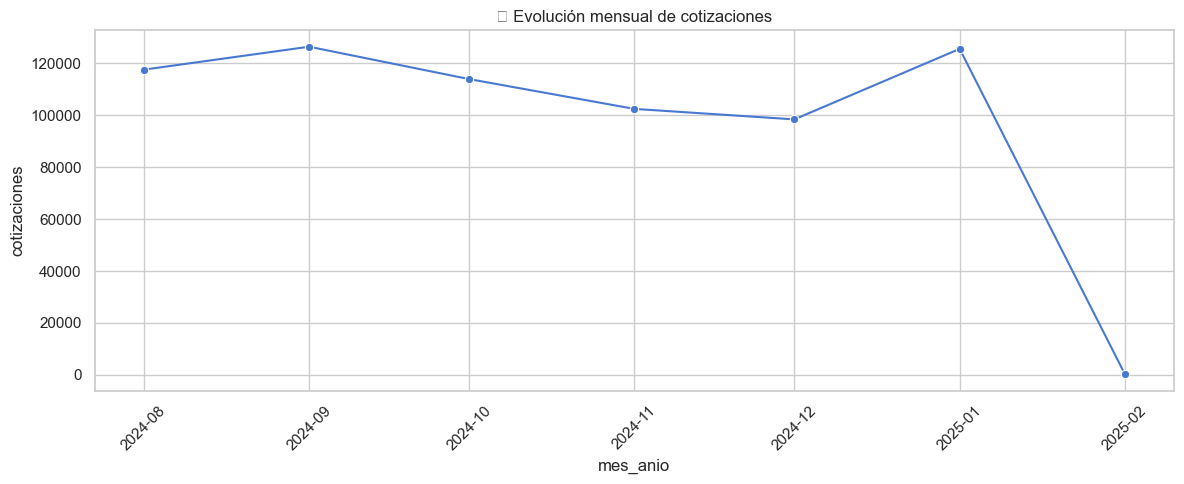

In [37]:
df_filtered['mes_anio'] = df_filtered['cotizacion_fecha'].dt.to_period('M').dt.to_timestamp()

cot_mensual = df_filtered.groupby('mes_anio').size().reset_index(name='cotizaciones')

plt.figure(figsize=(12,5))
sns.lineplot(data=cot_mensual, x='mes_anio', y='cotizaciones', marker='o')
plt.title("📈 Evolución mensual de cotizaciones")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\norma\AppData\Local\Temp\ipykernel_32728\369739907.py:6: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


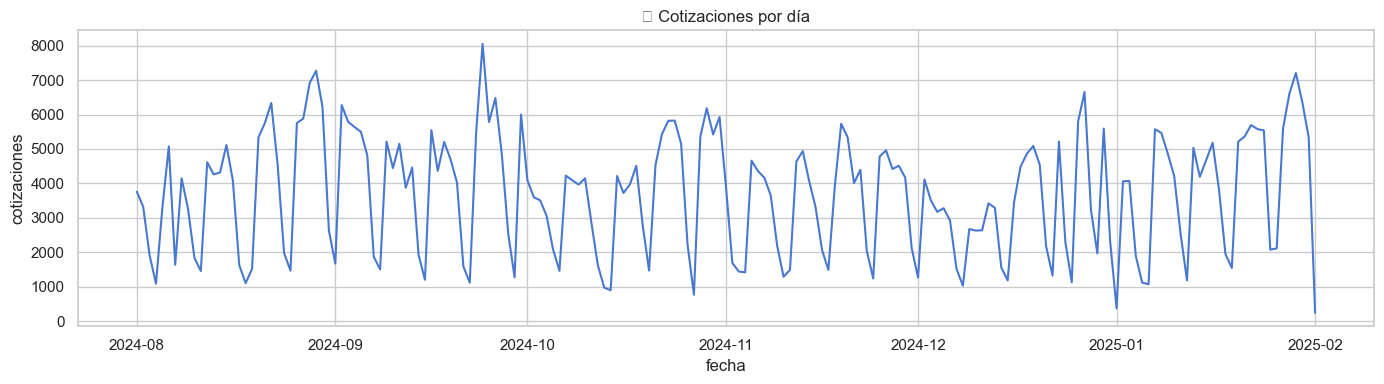

In [38]:
cot_diaria = df_filtered.groupby('fecha').size().reset_index(name='cotizaciones')

plt.figure(figsize=(14,4))
sns.lineplot(data=cot_diaria, x='fecha', y='cotizaciones')
plt.title("📆 Cotizaciones por día")
plt.tight_layout()
plt.show()

C:\Users\norma\AppData\Local\Temp\ipykernel_32728\2916170581.py:8: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


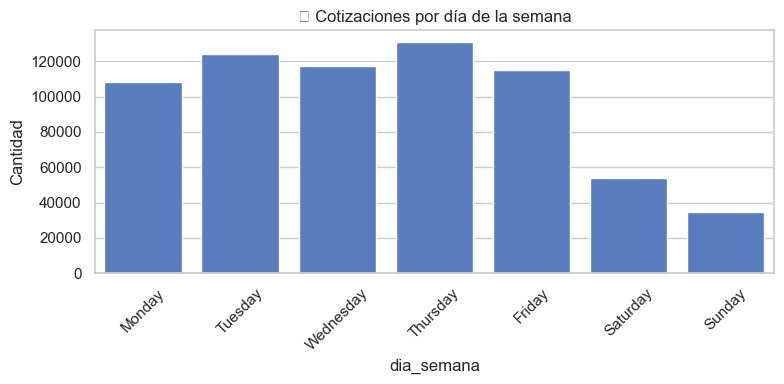

In [39]:
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8,4))
sns.countplot(data=df_filtered, x='dia_semana', order=orden_dias)
plt.title("🗓 Cotizaciones por día de la semana")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Separar aseguradora_producto
df_filtered[['aseguradora_origen', 'producto_origen']] = df_filtered['aseguradora_producto'].str.split('_', n=1, expand=True)

In [41]:
cot_mensual_aseg = (
    df_filtered
    .groupby(['mes_anio', 'aseguradora_origen'])
    .size()
    .reset_index(name='n_cotizaciones')
)

C:\Users\norma\AppData\Local\Temp\ipykernel_32728\3624186004.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


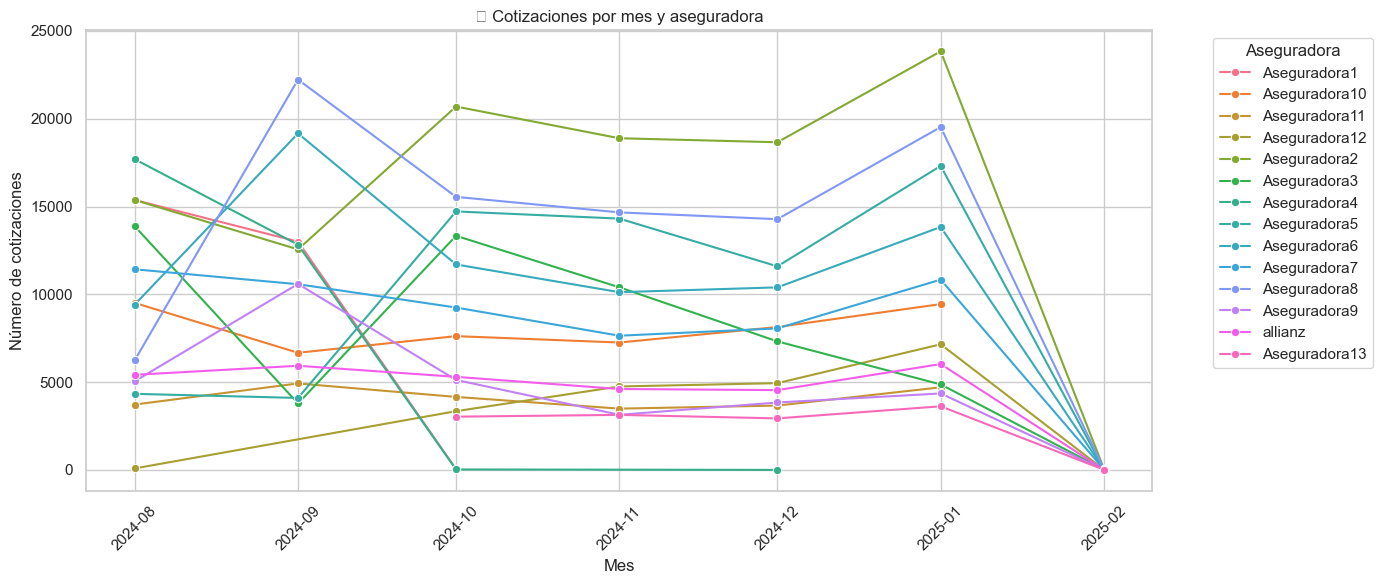

In [42]:
plt.figure(figsize=(14,6))
sns.lineplot(
    data=cot_mensual_aseg,
    x='mes_anio',
    y='n_cotizaciones',
    hue='aseguradora_origen',
    marker='o'
)
plt.title("📈 Cotizaciones por mes y aseguradora")
plt.xlabel("Mes")
plt.ylabel("Número de cotizaciones")
plt.xticks(rotation=45)
plt.legend(title="Aseguradora", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
df_filtered['mes_anio'] = pd.to_datetime(df_filtered['cotizacion_fecha']).dt.to_period('M').dt.to_timestamp()

cot_mensual_genero = (
    df_filtered
    .groupby(['mes_anio', 'genero'])
    .size()
    .reset_index(name='n_cotizaciones')
)

In [44]:
import plotly.express as px

fig = px.line(
    cot_mensual_genero,
    x='mes_anio',
    y='n_cotizaciones',
    color='genero',
    markers=True,
    title="📈 Cotizaciones mensuales por género"
)

fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Número de cotizaciones",
    legend_title="Género",
    hovermode="x unified",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

fig.show()

In [45]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   fecha_registro             684316 non-null  datetime64[ns]
 1   comparison_id              684316 non-null  object        
 2   fecha_nacimiento           582229 non-null  object        
 3   edad                       684316 non-null  int64         
 4   ocupacion                  684316 non-null  object        
 5   tipo_identificacion        684316 non-null  object        
 6   genero                     684316 non-null  object        
 7   fasecolda_id               684316 non-null  object        
 8   marca                      684316 non-null  object        
 9   referencia_vehiculo        684316 non-null  object        
 10  tipo_caja                  684316 non-null  object        
 11  valor_fasecolda            684316 non-null  int64   

In [46]:
# Eliminar columnas de fecha para depurar
df_filtered.drop(columns=['dia', 'fecha', 'hora'], inplace=True)
# Renombrar columnas
#df_filtered.rename(columns={'fecha_registro_fecha': 'fecha_registro', 'cotizacion_fecha_fecha': 'cotizacion_fecha'}, inplace=True)

### Cardinalidad de variables

In [47]:
cardinalidad = df_filtered.nunique().sort_values(ascending=False)
cardinalidad.to_frame(name="valores_unicos")

,valores_unicos
valor_prima,591297
comparison_id,34933
fecha_nacimiento,13097
fasecolda_id,2126
referencia_vehiculo,2124
valor_fasecolda,1377
dane_id,437
ciudad,424
cotizacion_fecha,185
fecha_registro,184


### Estadísticas descriptivas básicas

In [48]:
ids_columns = ['comparison_id', 'fasecolda_id', 'dane_id', 'departamento_id']

In [49]:
df_filtered.drop(columns=ids_columns).describe().T

,count,mean,min,25%,50%,75%,max,std
fecha_registro,684316,2024-10-30 15:59:01.458624512,2024-08-01 00:00:00,2024-09-12 00:00:00,2024-10-28 00:00:00,2024-12-18 00:00:00,2025-01-31 00:00:00,NaN
edad,684316.0,41.377748,20.0,31.0,39.0,49.0,1825.0,13.669632
valor_fasecolda,684316.0,47257119.10586,4800000.0,32900000.0,41900000.0,56500000.0,901000000.0,23309176.088565
modelo,684316.0,2017.516029,1980.0,2015.0,2018.0,2021.0,2026.0,4.469382
cotizacion_fecha,684316,2024-10-31 10:05:46.997585408,2024-08-01 00:00:00,2024-09-13 00:00:00,2024-10-29 00:00:00,2024-12-19 00:00:00,2025-02-01 00:00:00,NaN
valor_prima,684316.0,4213298.461782,11108.7,2477918.2,3572684.25,5181494.25,88460416.5,2616376.668826
delta_minutos,684316.0,1086.758983,0.0,0.0,0.0,0.0,43200.0,4622.446538
anio,684316.0,2024.183786,2024.0,2024.0,2024.0,2024.0,2025.0,0.38731
mes,684316.0,8.255326,1.0,8.0,9.0,11.0,12.0,3.665108
mes_anio,684316,2024-10-15 07:30:01.294138624,2024-08-01 00:00:00,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-12-01 00:00:00,2025-02-01 00:00:00,NaN


In [50]:
# Seleccionar solo variables categóricas excluyendo los IDs
cat_cols = df_filtered.select_dtypes(include='object').columns.difference(ids_columns)

# Descriptivo base
desc = df_filtered[cat_cols].describe().T

# Calcular porcentaje del valor top
desc['top_percent'] = (
    desc['freq'] / df_filtered.shape[0] * 100
).round(2)

desc[['count', 'unique', 'top', 'freq', 'top_percent']]

,count,unique,top,freq,top_percent
aseguradora_origen,684316,14,Aseguradora2,110059,16.083067
aseguradora_producto,684316,60,Aseguradora8_Todo Riesgo Bajo,78660,11.49469
ciudad,684316,424,Bogotá D.C.,218850,31.980839
departamento,684316,30,Bogotá D.C.,218850,31.980839
dia_semana,684316,7,Thursday,130935,19.133704
emitido_producto,163291,54,Aseguradora2_Todo Riesgo Bajo,17910,2.617212
fecha_nacimiento,582229,13097,2000-05-12,726,0.106091
genero,684316,2,Masculino,416560,60.872462
marca,684316,46,RENAULT,162558,23.754815
ocupacion,684316,7,Estudiante,562942,82.263457


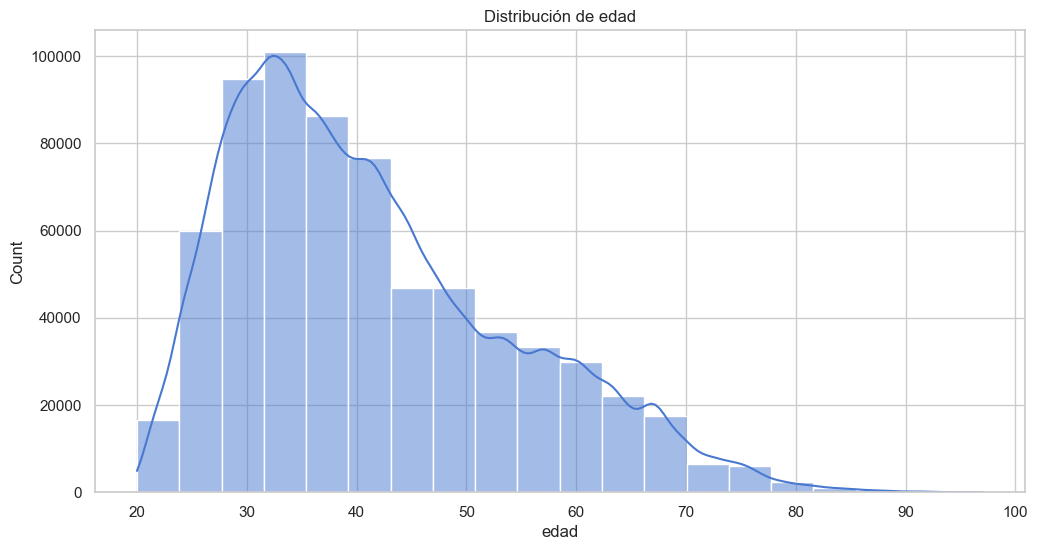

In [104]:
df_filtered['edad'].describe()

sns.histplot(df_filtered['edad'], bins=20, kde=True)
plt.title("Distribución de edad")
plt.show()

### Variable objetivo

In [105]:
df_filtered['emitido'] = df_filtered['emitido_producto'].notna().astype(int)
emitido_counts = df_filtered['emitido'].value_counts(normalize=True).rename_axis('emitido').reset_index(name='proporcion')
emitido_counts['proporcion'] = (emitido_counts['proporcion'] * 100).round(2)
emitido_counts

,emitido,proporcion
0,0,76.14
1,1,23.86


### Eliminar columnas redundantes o sin información útil

In [55]:
df_filtered.drop(columns=['fecha_nacimiento'], inplace=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   fecha_registro             684316 non-null  datetime64[ns]
 1   comparison_id              684316 non-null  object        
 2   edad                       684316 non-null  int64         
 3   ocupacion                  684316 non-null  object        
 4   tipo_identificacion        684316 non-null  object        
 5   genero                     684316 non-null  object        
 6   fasecolda_id               684316 non-null  object        
 7   marca                      684316 non-null  object        
 8   referencia_vehiculo        684316 non-null  object        
 9   tipo_caja                  684316 non-null  object        
 10  valor_fasecolda            684316 non-null  int64         
 11  modelo                     684316 non-null  int64   

In [66]:
df_filtered['modelo'].value_counts(normalize=True).rename_axis('modelo').reset_index(name='proporcion')

,modelo,proporcion
0,2019,0.087875
1,2022,0.087394
2,2020,0.082522
3,2017,0.079243
4,2023,0.077908
5,2015,0.074796
6,2016,0.072600
7,2018,0.071017
8,2013,0.053817
9,2021,0.053619


In [65]:
df_filtered['vehiculo_nuevo'].value_counts(normalize=True).rename_axis('vehiculo_nuevo').reset_index(name='proporcion')

,vehiculo_nuevo,proporcion
0,Usado,0.967147
1,Nuevo,0.032853


In [59]:
df_filtered['ocupacion'].value_counts(normalize=True).rename_axis('ocupacion').reset_index(name='proporcion')

,ocupacion,proporcion
0,Estudiante,0.822635
1,Empleado,0.146147
2,Independiente,0.019918
3,Inversionista,0.004624
4,Pensionado,0.003415
5,Rentista,0.002800
6,Comerciante,0.000462


In [62]:
df_filtered['ciudad'].value_counts(normalize=True).rename_axis('ciudad').reset_index(name='proporcion')

,ciudad,proporcion
0,Bogotá D.C.,0.319808
1,Medellin,0.136392
2,Cali,0.103243
3,Barranquilla,0.040794
4,Pereira,0.020385
...,...,...
419,Gachala,0.000006
420,San Benito Abad,0.000006
421,Pensilvania,0.000004
422,Morales,0.000004


In [63]:
df_filtered['departamento'].value_counts(normalize=True).rename_axis('departamento').reset_index(name='proporcion')

,departamento,proporcion
0,Bogotá D.C.,0.319808
1,Antioquia,0.225297
2,Valle del Cauca,0.133349
3,Cundinamarca,0.052786
4,Atlántico,0.050057
5,Santander,0.029879
6,Risaralda,0.028827
7,Caldas,0.022516
8,Bolívar,0.019757
9,Tolima,0.018147


In [106]:
df_filtered['ciudad_dpto'] = df_filtered['ciudad'] + ' - ' + df_filtered['departamento']

In [107]:
data_path = "C:/Allianz/prueba_allianz/data/processed/allianz_consolidado_imputado.csv"
df_filtered.to_csv(data_path, sep=";", encoding="utf-8", index=False)

In [108]:
df_filtered.columns

Index(['fecha_registro', 'comparison_id', 'edad', 'ocupacion',
       'tipo_identificacion', 'genero', 'fasecolda_id', 'marca',
       'referencia_vehiculo', 'tipo_caja', 'valor_fasecolda', 'modelo',
       'dane_id', 'ciudad', 'departamento_id', 'departamento',
       'vehiculo_nuevo', 'aseguradora_producto', 'cotizacion_fecha',
       'valor_prima', 'perdida_total_cobertura', 'perdida_parcial_deducible',
       'rce_limite_unico', 'emitido_producto', 'emitido_cotizacion',
       'source_file', 'delta_minutos', 'anio', 'mes', 'dia_semana', 'mes_anio',
       'aseguradora_origen', 'producto_origen', 'emitido', 'ciudad_dpto'],
      dtype='object')

In [109]:
df_filtered['emitido'].value_counts()

emitido
0    521025
1    163291
Name: count, dtype: int64

In [110]:
df_filtered['emitido_cotizacion'].value_counts()

emitido_cotizacion
False    681962
True       2354
Name: count, dtype: int64

In [116]:
df_filtered['emitido_producto'].isna().sum()

np.int64(0)

In [115]:
df_filtered['emitido_producto'] = df_filtered['emitido_producto'].fillna('No_emitido')

In [ ]:
#deleted_columns = ['fecha_registro', 'tipo_identificacion', 'dane_id', 'departamento_id', 'cotizacion_fecha', 'source_file', 'emitido_cotizacion']

In [100]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   fecha_registro             684316 non-null  datetime64[ns]
 1   comparison_id              684316 non-null  object        
 2   edad                       684316 non-null  int64         
 3   ocupacion                  684316 non-null  object        
 4   tipo_identificacion        684316 non-null  object        
 5   genero                     684316 non-null  object        
 6   fasecolda_id               684316 non-null  object        
 7   marca                      684316 non-null  object        
 8   referencia_vehiculo        684316 non-null  object        
 9   tipo_caja                  684316 non-null  object        
 10  valor_fasecolda            684316 non-null  int64         
 11  modelo                     684316 non-null  int64   

In [117]:
data_path = "C:/Allianz/prueba_allianz/data/processed/allianz_consolidado_imputado.csv"
df_filtered.to_csv(data_path, sep=";", encoding="utf-8", index=False)